# Genre Prediction Based on Lyrics

## Introduzione
La relazione si pone l'obiettivo di definire un predittore di genere musicale basato su lyrics (testi delle canzoni). Il dataset utilizzato è una istanza di https://tmthyjames.github.io/2018/january/Cypher/ (Cypher, https://github.com/tmthyjames/cypher). Il progetto è attualmente dismesso, ma è possibile reperire in rete alcune istanze (tipicamente da altri progetti github). Il dataset consiste in un documento in formato CSV in cui sono presenti informazioni riguardo brani musicali di vari generi: titolo, cantante, album, genere, etc. ... Su tale dataset si sviluppa l'allenamento del modello di machine learning ed i relativi test di verifica dell'apprendimento. Una volta allenata la rete neurale si proveranno ad affettuare una serie di predizioni con nuovi brani e verranno verificati i risultati.

Contenuto
- Caricamento dei Dati
- Processamento dei dati
- Allenamento del Modello
- Analisi e Test

#### Prerequisiti
Una lista di librerie necessarie al corretto funzionamento del notebook:
- pandas
- numpy
- sklearn
- random

## Caricamento dei Dati - OK
Per caricare i dati in formato csv all'interno del programma si utilizza pandas, in particolare il metodo __read_csv__ andando a creare un oggetto denominato dataframe. Ai fini di poter raggruppare alcuni dei sottogeneri o derivati del genere rock è stato creato un alias chiamato _alt rock_ che raggruppa: screamo, punk rock ed heavy metal.

In [86]:
import pandas as pd
import numpy as np

df = pd.read_csv('lyrics.csv', on_bad_lines='skip')

df['ranker_genre'] = np.where(
    (df['ranker_genre'] == 'screamo')|
    (df['ranker_genre'] == 'punk rock')|
    (df['ranker_genre'] == 'heavy metal'), 
    'alt rock', 
    df['ranker_genre']
)

/tmp/ipykernel_885560/198304336.py:4: DtypeWarning: Columns (2,5,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('lyrics.csv', on_bad_lines='skip')


<class 'pandas.core.frame.DataFrame'>


In Una volta definito il dataframe si procede con il raggruppamento sulle seguenti: _song_, _year_, _album_, _genre_, _artist_, *ranker_genre*. Si applicano poi vari metodi che anticipano la seguente fase di preprocessing sui titoli delle canzoni, andando ad effettuare il lowering (transformazione da caratteri in maiuscolo in minuscolo), rimozione di caratteri non necessari e operazioni di _join_ su spazi bianchi.

In [87]:
# group creation
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']

# fixing the name of the song
lyrics_by_song = df.sort_values(group)\
        .groupby(group).lyric\
        .apply(' '.join)\
        .apply(lambda x: x.lower())\
        .reset_index(name='lyric')

lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

/tmp/ipykernel_885560/602755275.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')


In [85]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
import random

# select genre to analyze
genres = [
    'pop', 'alt rock', 'Hip Hop',
]

LYRIC_LEN = 400 # each song has to be > 400 characters
N = random.randint(1000, 3000) # number of records to pull from each genre
RANDOM_SEED = random.randint(200, 1000) # random seed to make results repeatable

train_df = pd.DataFrame()
test_df = pd.DataFrame()
for genre in genres: # loop over each genre

    # create a subset
    subset = lyrics_by_song[  
        (lyrics_by_song.ranker_genre==genre) & 
        (lyrics_by_song.lyric.str.len() > LYRIC_LEN)
    ]
    
    train_set = subset.sample(n=N, random_state=RANDOM_SEED, replace=True)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set) # append subsets to the master sets
    test_df = test_df.append(test_set)
    
train_df = shuffle(train_df)
test_df = shuffle(test_df)

/tmp/ipykernel_885560/705977847.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_885560/705977847.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_885560/705977847.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(train_set) # append subsets to the master sets
/tmp/ipykernel_885560/705977847.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(test_set)
/tmp/ipykernel_885560/705977847.py:23: FutureWarning: The frame.append method is depre

A questo punto è necessario effettuare l'allenamento utilizzando l'analisi di frequenza and sklearn e countvectorizer. Il seconodo è un modo veloce per allenare un modello con analisi di frequenza. Successivamente andremo anche a vedere come implementare un metodo più complesso come TfidVectorizer.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import *

# define our model
text_clf = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.7990875749172556

Aggiunta di TfidVectorizer. Mettici una finestrella sul funzionamento di TfidVectorizer.

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.7944288685900335

Ora proviamo a fare della lemmatization

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

stop = list(set(stopwords.words('english'))) # stopwords
wnl = WordNetLemmatizer() # lemmatizer

def tokenizer(x): # custom tokenizer
    return (
        wnl.lemmatize(w) 
        for w in word_tokenize(x) 
        if len(w) > 2 and w.isalnum() # only words that are > 2 characters
    )                                 # and is alpha-numeric

# define our model
text_clf = Pipeline(
    [('vect', TfidfVectorizer(
        ngram_range=(1, 2), # include bigrams
        tokenizer=tokenizer,
        stop_words=stop,
        max_df=0.4, # ignore terms that appear in more than 40% of documents
        min_df=4)), # ignore terms that appear in less than 4 documents
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB(alpha=0.1))])

# train our model on training data
text_clf.fit(train_df.lyric, train_df.ranker_genre)  

# score our model on testing data
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

/home/maxbubblegum/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/maxbubblegum/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(


0.907388984353803

Vediamo la confusion matrix

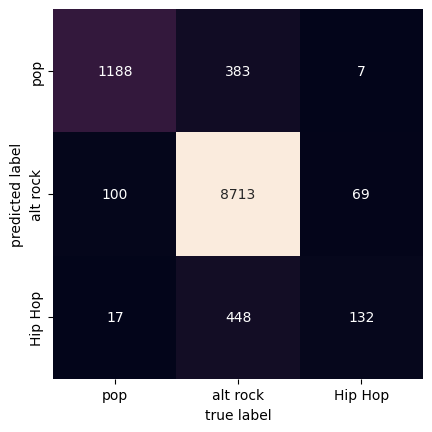

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(
    mat.T, square=True, annot=True, fmt='d', cbar=False,
    xticklabels=genres, 
    yticklabels=genres
)
plt.xlabel('true label')
plt.ylabel('predicted label');

Breve analisi su recall, precision, fscore, partendo dalla confusion matrix:

In [74]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)

for n,genre in enumerate(genres):
    genre = genre.upper()
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

POP_precision: 0.752851711026616
POP_recall: 0.9103448275862069
POP_fscore: 0.8241415192507805
POP_support: 1305

ALT ROCK_precision: 0.9809727538842603
ALT ROCK_recall: 0.912929589270746
ALT ROCK_fscore: 0.9457288613915119
ALT ROCK_support: 9544

HIP HOP_precision: 0.22110552763819097
HIP HOP_recall: 0.6346153846153846
HIP HOP_fscore: 0.3279503105590062
HIP HOP_support: 208



Proviamo a fare una random prediction:

In [75]:
text_clf.predict(
    [
        "i stand for the red white and blue",
        "flow so smooth they say i rap in cursive", #bars *insert fire emoji*
        "take my heart and carve it out",
        "there is no end to the madness",
        "sitting on my front porch drinking sweet tea",
        "sitting on my front porch sippin on cognac",
        "dog died and my pick up truck wont start",
        "im invisible and the drugs wont help",
        "i hope you choke in your sleep thinking of me",
        "i wonder what genre a song about data science and naive bayes and hyper parameters and maybe a little scatter plots would be"
    ]
)

array(['alt rock', 'Hip Hop', 'pop', 'alt rock', 'alt rock', 'Hip Hop',
       'Hip Hop', 'alt rock', 'alt rock', 'Hip Hop'], dtype='<U8')